In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format='retina'

import sys
sys.path.append("../")

In [2]:
import numpy as np, torch
import scipy.stats as st
import itertools
from basis_decomposition.run import compute_basis_decomposition, InferenceMode, plot_basis, get_basis
from pyro.infer import Predictive
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns

In [3]:
# load the patterns
adata = sc.read_h5ad("../reproducibility/analysis/AML1.decipher.post-analyzed.h5ad")

gene_patterns = torch.FloatTensor(adata.uns["decipher_gene_patterns_cropped"]["patterns"])
gene_patterns_times = torch.FloatTensor(adata.uns["decipher_gene_patterns_cropped"]["times"])

In [4]:
trajectory_model, guide, times, samples, gene_scales = compute_basis_decomposition(
    gene_patterns,
    InferenceMode.GAUSSIAN_BETA_ONLY,
    n_basis=5,
    n_iter=10_000,
    show_basis=False,
    lr=1e-2,
    beta_prior=1,
    seed=0,
    times=gene_patterns_times
)
gene_scales = gene_scales.detach().numpy()
betas = samples["beta"]["mean"].squeeze().detach().numpy()
basis = get_basis(trajectory_model, guide, gene_patterns, times)

[iteration 0001] loss: 427481.0479 0.4272834062576294 tensor(0.2990)
[iteration 0101] loss: 127277.1091 0.26005494594573975 tensor(0.1820)
[iteration 0201] loss: 30059.6139 0.18921972811222076 tensor(0.1324)
[iteration 0301] loss: -155882.7118 0.06385097652673721 tensor(0.0447)
[iteration 0401] loss: -317874.9855 0.03717483952641487 tensor(0.0260)
[iteration 0501] loss: -421297.4891 0.025853900238871574 tensor(0.0181)
[iteration 0601] loss: -467860.1529 0.022136488929390907 tensor(0.0155)
[iteration 0701] loss: -476652.4230 0.0223905798047781 tensor(0.0157)
[iteration 0801] loss: -497486.3846 0.022006070241332054 tensor(0.0154)
[iteration 0901] loss: -503730.5000 0.022044893354177475 tensor(0.0154)
[iteration 1001] loss: -513417.0816 0.020862223580479622 tensor(0.0146)
[iteration 1101] loss: -513378.2324 0.021320007741451263 tensor(0.0149)
[iteration 1201] loss: -526155.8385 0.020348504185676575 tensor(0.0142)
[iteration 1301] loss: -532172.2148 0.019979706034064293 tensor(0.0140)
[ite

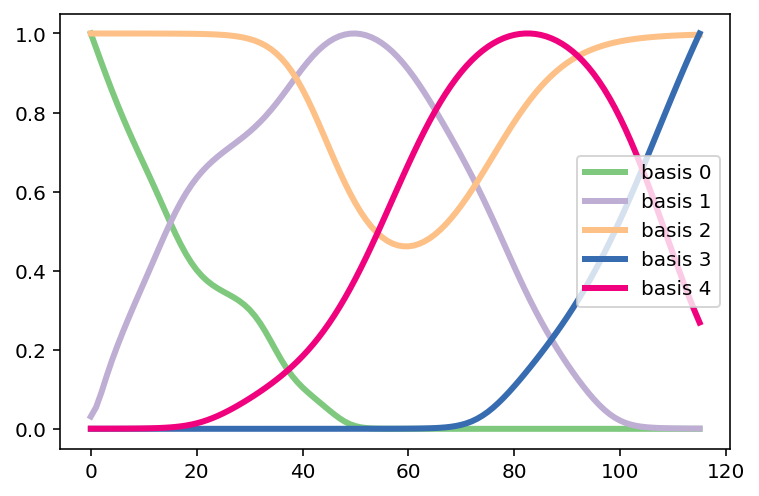

In [5]:
colors = sns.color_palette("Accent")
colors = [colors[i] for i in [0, 1, 2, 4, 5]]
plot_basis(trajectory_model, guide, gene_patterns, times, colors)
plt.legend()

In [6]:
diff_betas = betas[1] - betas[0]
disruption_scores = np.linalg.norm(diff_betas, axis=1)
# wald_stat = np.einsum("gk, kl, gl -> g", diff_betas, np.linalg.inv(np.cov(diff_betas, rowvar=False)), diff_betas)


plt.scatter(disruption_scores,wald_stat)

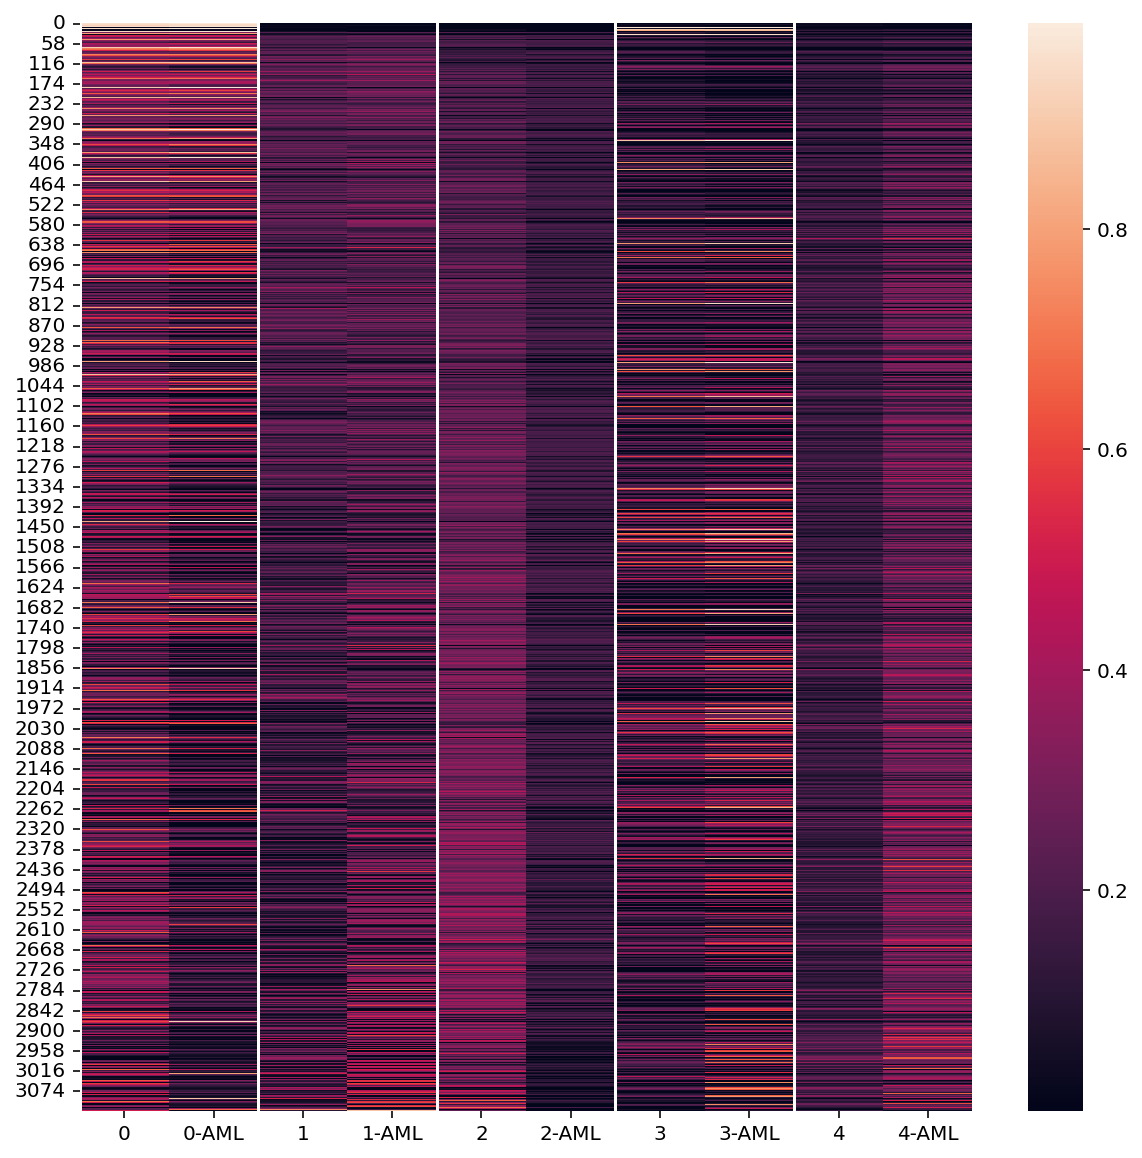

In [7]:
plt.figure(figsize=[10, 10])
cc = sns.heatmap(
    betas
    .transpose(1, 2, 0)
    .reshape(3130, -1)
    [np.argsort(disruption_scores)],
)
labels = []
for i in range(trajectory_model.K):
    cc.axvline(2 * i, c="white")
    labels.extend([f"{i}", f"{i}-AML"])
cc.set_xticklabels(labels);

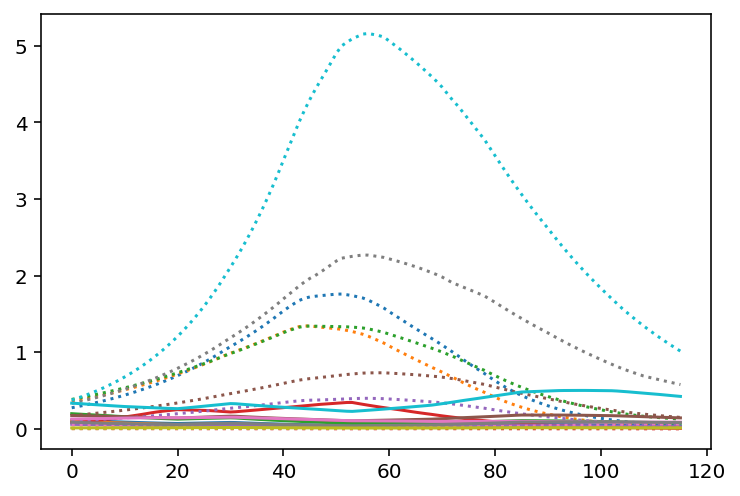

In [8]:
m = 10
palette = sns.color_palette(n_colors=m)
for i in range(m):
    plt.plot(
        gene_patterns.numpy()[0,np.argsort(disruption_scores)[::-1][i],:].T, color=palette[i]
    )
    plt.plot(
        gene_patterns.numpy()[1,np.argsort(disruption_scores)[::-1][i],:].T, color=palette[i], ls=":"
    )